<a href="https://colab.research.google.com/github/Ahmed-Laaziz/Machine_Learning_With_Spark/blob/main/Machine_Learning_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

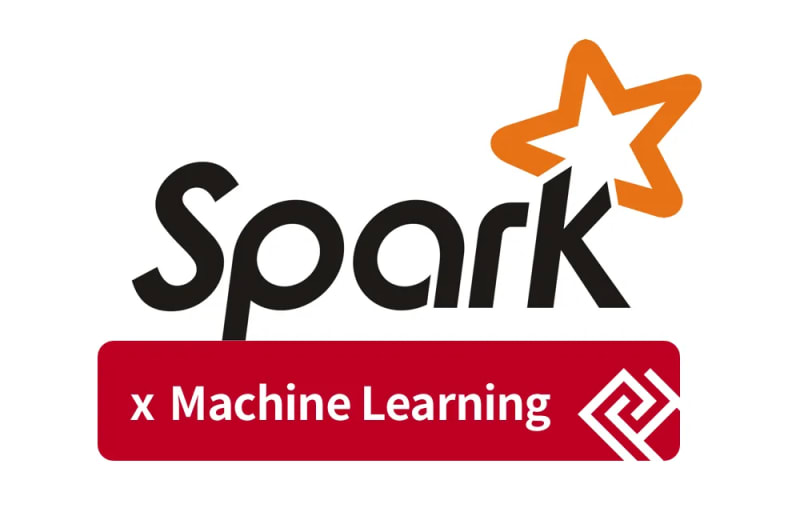

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=f5b15aff040fcd9e579c7b0f38acf422f203ff034719e9106f84977272350087
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Datacamp Pyspark Tutorial") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "10g") \
    .getOrCreate()


In [6]:
import pandas as pd

# Read Excel file into a Pandas dataframe
df_pandas = pd.read_excel("/content/drive/MyDrive/Online Retail.xlsx")

# Convert Pandas dataframe to Spark dataframe
df = spark.createDataFrame(df_pandas)

# Show the data in Spark dataframe
df.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United Kingdom|
|   536365|    21730|GLASS S

In [7]:
df.count()

541909

In [8]:
df.select('CustomerID').distinct().count()

4373

In [16]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3951|
|        Germany|           95|
|         France|           88|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           22|
|       Portugal|           20|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|    Unspecified|            5|
+---------------+-------------+
only showing top 20 rows



In [17]:
df.orderBy(desc('InvoiceDate')).show(1)

+---------+---------+--------------------+--------+-------------------+---------+----------+-------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+-------+
|   581587|    22631|CIRCUS PARADE LUN...|      12|2011-12-09 12:50:00|     1.95|   12680.0| France|
+---------+---------+--------------------+--------+-------------------+---------+----------+-------+
only showing top 1 row



In [18]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'yy/MM/dd HH:mm'))
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



In [19]:
df.show(1)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|               date|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|2010-12-01 08:26:00|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------------------+
only showing top 1 row



In [20]:
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



In [31]:
df = df.withColumn("from_date", lit("10/1/12 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))

df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

In [32]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

In [23]:
df2.show(5,0)

+---------+---------+---------+------------------------+--------+-------------------+---------+----------+--------------+-------------------+-------------------+
|recency  |InvoiceNo|StockCode|Description             |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |date               |from_date          |
+---------+---------+---------+------------------------+--------+-------------------+---------+----------+--------------+-------------------+-------------------+
|-27704940|544815   |22421    |LIPSTICK PEN FUSCHIA    |12      |2011-02-23 16:37:00|0.42     |17171.0   |United Kingdom|2011-02-23 16:37:00|2012-01-10 08:26:00|
|-27704940|544815   |22419    |LIPSTICK PEN RED        |12      |2011-02-23 16:37:00|0.42     |17171.0   |United Kingdom|2011-02-23 16:37:00|2012-01-10 08:26:00|
|-27704940|544815   |22420    |LIPSTICK PEN BABY PINK  |12      |2011-02-23 16:37:00|0.42     |17171.0   |United Kingdom|2011-02-23 16:37:00|2012-01-10 08:26:00|
|-27704940|544815   |22077  

In [33]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

In [25]:
df_freq.show(5)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|   12493.0|       11|
|   18114.0|       28|
|   13533.0|       33|
|   13973.0|       11|
|   13956.0|       21|
+----------+---------+
only showing top 5 rows



In [34]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')

In [35]:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

In [36]:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

In [37]:
finaldf = m_val.join(df3,on='CustomerID',how='inner')

In [38]:
finaldf.show()

+----------+------------------+--------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+
|CustomerID|    monetary_value| recency|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|       Country|               date|          from_date|frequency|
+----------+------------------+--------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+
|   12493.0|184.29000000000002|45885060|   558124|    23084|  RABBIT NIGHT LIGHT|      12|2011-06-27 10:17:00|     2.08|        France|2011-06-27 10:17:00|2010-01-12 08:26:00|       11|
|   12493.0|184.29000000000002|45885060|   558124|    23199|    JUMBO BAG APPLES|      10|2011-06-27 10:17:00|     2.08|        France|2011-06-27 10:17:00|2010-01-12 08:26:00|       11|
|   12493.0|184.29000000000002|45885060|   558124|    22385|JUMBO BAG 

In [39]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [40]:
data_scale_output.select('standardized').show(2,truncate=False)

+------------------------------------------------------------+
|standardized                                                |
+------------------------------------------------------------+
|[5.304657934948711,0.02568332539543099,0.03458527834132549] |
|[5.5871915596098525,0.02568332539543099,0.03458527834132549]|
+------------------------------------------------------------+
only showing top 2 rows



In [41]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

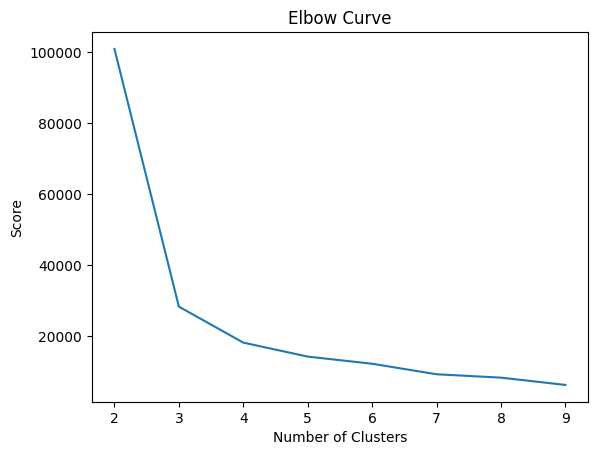

In [42]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [58]:
KMeans_algo=KMeans(featuresCol='standardized', k=3)
KMeans_fit=KMeans_algo.fit(data_scale_output)

In [59]:
preds=KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+----------+------------------+--------+---------+---------+--------------------------+--------+-------------------+---------+-------+-------------------+-------------------+---------+------------------------------------+------------------------------------------------------------+----------+
|CustomerID|monetary_value    |recency |InvoiceNo|StockCode|Description               |Quantity|InvoiceDate        |UnitPrice|Country|date               |from_date          |frequency|features                            |standardized                                                |prediction|
+----------+------------------+--------+---------+---------+--------------------------+--------+-------------------+---------+-------+-------------------+-------------------+---------+------------------------------------+------------------------------------------------------------+----------+
|12493.0   |184.29000000000002|45885060|558124   |23084    |RABBIT NIGHT LIGHT        |12      |2011-06-27 10:17:00|2.

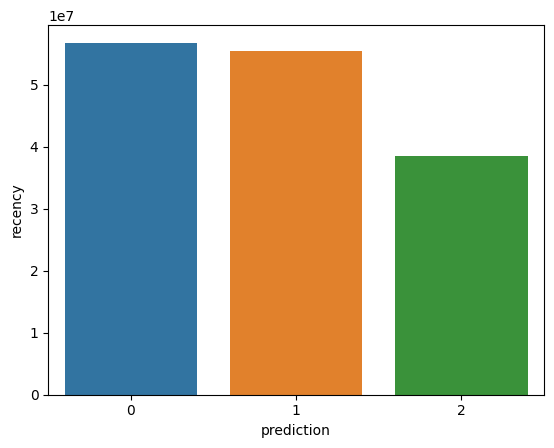

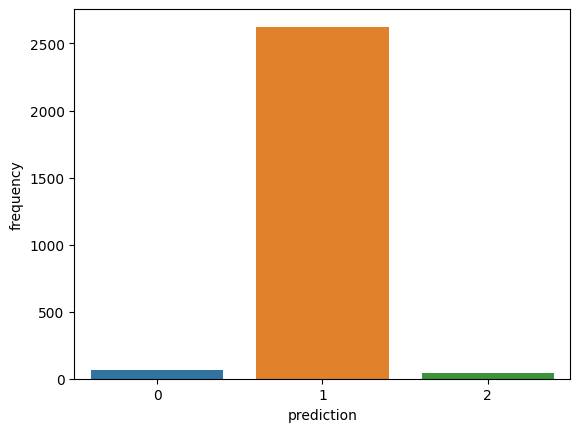

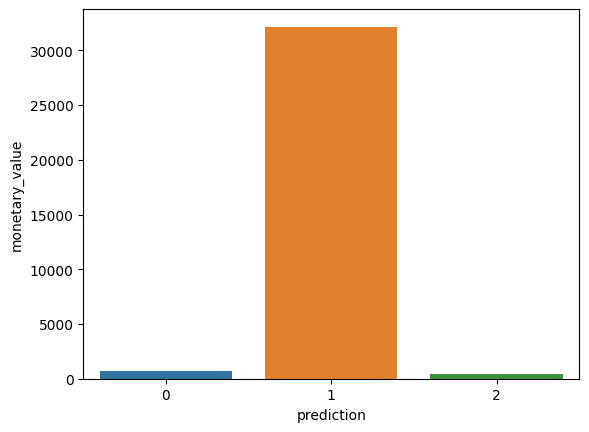

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()